# Frequency Analysis of Mass Density Extractions

In [1]:
import pandas as pd
# from pandas import read_csv as pd_read_csv
# from pandas import Series as pd_Series
import numpy  as np

from pygeodyn.pygeodyn_plot_scalingfactors import orbit_avg_generic
import plotly.graph_objects as go
from plotly.offline import plot, iplot
from plotly.subplots import make_subplots

from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)
    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration
    return date.year + fraction



from scipy.signal import butter, filtfilt
def filter_signal(data, sample_freq, lowcut=1e-4, highcut=1e-1, order=3):
    """A convenience method to apply butterworth filters to the data.

       data: array of samples at the given sampling frequency (no gaps)

       sample_freq: sampling frequency that data is given in (Hz)
                    [Default: 1/60 Hz (60 s sample period)]

       lowcut: low cutoff frequency (Hz)
               [Default: 1e-4 Hz, (10,000 s period)]

       highcut: high cutoff frequency (Hz)
                [Default: 1e-1 Hz, (10 s period)]

       order: Order of the butterworth filter to use
              [Default: 3]
    """

    nyquist = 0.5*sample_freq
    low = lowcut / nyquist
    high = highcut / nyquist

    # Create the butterworth filters
    # If the sample frequency is high enough, make it a band pass
    # otherwise, it will be a highpass filter
    # TODO: Might want to add in a low pass filter option?
    #       Or does the bandpass account for that automatically?
    if sample_freq > highcut:
        b, a = butter(order, [low, high], btype='band')
    else:
        b, a = butter(order, low, btype='highpass')

    # Apply the filter coefficients to the data and return
    return filtfilt(b, a, data)

### if 10s cadence

In [2]:
# gfo_df = gfo_df.query("Date >= '2018-11-01' and Date < '2018-11-10'")
# gfo_df = gfo_df.reset_index(drop=True)



# y_signal = gfo_df['D500_gfo'].values
# x_date =  gfo_df['Date'].values 
# T = 10  # period

# N        = len(y_signal)
# unixtimes = pd.Series([ pd.Timestamp(date)  for date in x_date ])
# tim_unix =  [ ts.value/10**9  for ts in unixtimes ]
# x_time = tim_unix
# fs = 1/T   


### if orbit average

In [3]:
import pandas as pd
from pygeodyn.pygeodyn_plot_scalingfactors import orbit_avg_generic

gfo_file = 'gfo_6month.csv'
gfo_df = pd.read_csv(gfo_file, sep = ',',)

(timeavg_gfo,  denavg_gfo) = orbit_avg_generic(gfo_df['Date'], gfo_df['D500_gfo'], gfo_df['lat']) 
denavg_gfo = denavg_gfo[:-1]
del gfo_df

dat = denavg_gfo
title = 'Orbit Averaged Densities'
label = 'Rho'
units = 'kg/m^3'


# We also create a time array in years.
N = dat.size
t =  np.asarray([ toYearFraction(pd.to_datetime(ts))  for ts in timeavg_gfo ])
dt = np.diff(t).mean()   #period
t0 = t[0]
f_samp = 1/dt   


print(f"Period is             {dt} years")
print(f"Sampling Frequency is {f_samp}")


 


Period is             0.0001804246257554385 years
Sampling Frequency is 5542.480666444487


### Remove baseline, bandpass

#### Check FFT, PSD

 Signal is sampled at a rate f_s = 5542.480666444487 Hz. Period is 0.0001804246257554385s 


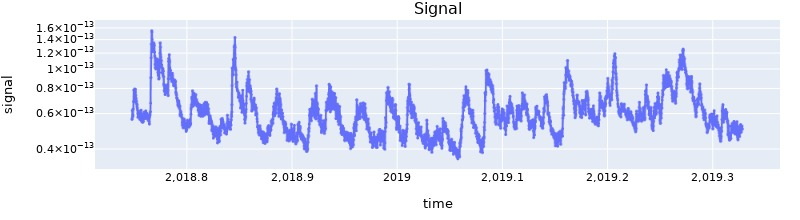

Dominant frequency at      1.7223370622885295 Hz
                           0.5806064456810011 s 

   0.6 s
   0.1 s
   0.0 s
   0.1 s
   0.0 s
   0.1 s
   0.0 s
   0.0 s
   0.0 s


In [4]:

from scipy.signal import detrend
print(f" Signal is sampled at a rate f_s = {f_samp} Hz. Period is {dt}s ")


fig = make_subplots(rows=1, cols=1,
                   subplot_titles=(["Signal"]))

################################################################################
#### Signal
fig.add_trace(go.Scattergl(x=t,
                         y=dat,
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=False),
                         row=1, col=1)
fig.update_yaxes(title_text="signal",  
                 type="log", exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="time", exponentformat= 'power',
                 row=1, col=1)
font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)

fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')




# fig = make_subplots(rows=4, cols=1,
#                    subplot_titles=("Signal", "FFT", "LombScargle Periodogram","PSD (welch)" ))
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=( "FFT",  "PSD (periodogram)"),#,"PSD (welch)"),
                   shared_xaxes=True)

################################################################################
#### FFT
fft_values_ = np.fft.rfft(   dat)
power_spectrum = 2.0/N * np.abs(fft_values_[0:N//2])[1:]
freqs       = np.fft.fftfreq(dat.size,d=1/f_samp)
freqs       = freqs[1:N//2]
#
    
    
fig.add_trace(go.Scattergl(x=  freqs,
                         y=  power_spectrum,
                           mode='markers+lines',
                            marker=dict(size=4),
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=1, col=1)
fig.update_yaxes(title_text="power",  
                 exponentformat= 'power',
#                            type='log',
                 row=1, col=1)
fig.update_xaxes(exponentformat= 'power',
                 type='log',
                 row=1, col=1)




################################################################################
####  PSD using Periodogram
from scipy.signal import periodogram
def get_psd_values(y_values,  f_s):
    f_values, psd_values = periodogram(y_values, fs=f_s)
    return f_values, psd_values
f_values, psd_values = get_psd_values(dat, f_samp)
f_values  = f_values[1:]
psd_values= psd_values[1:]

fig.add_trace(go.Scattergl(x=  f_values,
                         y=  psd_values,
                           mode='markers+lines',
                               marker=dict(size=4),
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=2, col=1)
fig.update_yaxes(title_text="PSD [V**2 / Hz]",  
                 exponentformat= 'power',
#                type='log',
                 row=2, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log',
                 row=2, col=1)




################################################################################

font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)
fig.update_layout(xaxis_showticklabels=True, xaxis2_showticklabels=True)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=500, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict)

fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)
fig.show(config = dict({
                'displayModeBar': False,
                'responsive': True,
                'staticPlot': False,
                'displaylogo': False,
                'showTips': False,
                }), 
#         renderer='jpg')
        )

index_max = np.argmax(psd_values)
print(f"Dominant frequency at      {f_values[index_max]} Hz")
print(f"                           {1/f_values[index_max]} s ")

print()
indexes = np.argsort(psd_values)

for i in np.arange(1,10):
    print(f" {1/f_values[indexes[-i]]:5.1f} s")
    



#### apply filts

In [5]:
dat_norm = (dat-dat.mean())/dat.std()     # baseline removal
# y_filt = filter_signal(dat, sample_freq=f_samp, lowcut=1e-8, highcut=1e-3, order=3)
y_filt = filter_signal(dat_norm, sample_freq=f_samp, lowcut=4, highcut=1500, order=3)



fig = make_subplots(rows=2, cols=1,
                   subplot_titles=(["Filter "]))

################################################################################
#### Signal
fig.add_trace(go.Scattergl(x=t,
                         y=dat,
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=False),
                         row=1, col=1)

fig.add_trace(go.Scattergl(x=t,
                         y=y_filt,
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=False),
                         row=2, col=1)


# fig.update_yaxes(title_text="signal",  
#                  exponentformat= 'power',
#                  row=1, col=1)
# fig.update_xaxes(title_text="time", exponentformat= 'power',
#                  row=1, col=1)
font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
                 )
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)


 Signal is sampled at a rate f_s = 5542.480666444487 Hz. Period is 0.0001804246257554385s 


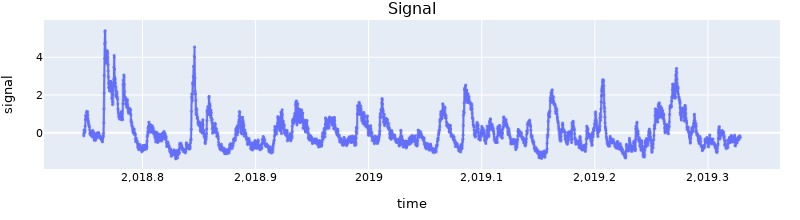

Dominant frequency at      12.056359436019706 Hz
                           0.08294377795442873 s 

  30.3 days
   6.8 days
  14.1 days
  35.3 days
  26.5 days
   8.8 days
   9.2 days
   5.6 days
  13.2 days


In [6]:

from scipy.signal import detrend
print(f" Signal is sampled at a rate f_s = {f_samp} Hz. Period is {dt}s ")


fig = make_subplots(rows=1, cols=1,
                   subplot_titles=(["Signal"]))

################################################################################
#### Signal
fig.add_trace(go.Scattergl(x=t,
                         y=y_filt,
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=False),
                         row=1, col=1)
fig.update_yaxes(title_text="signal",  
                 type="linear", exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="time", exponentformat= 'power',
                 row=1, col=1)
font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)

fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')




# fig = make_subplots(rows=4, cols=1,
#                    subplot_titles=("Signal", "FFT", "LombScargle Periodogram","PSD (welch)" ))
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=( "FFT",  "PSD (periodogram)"),#,"PSD (welch)"),
                   shared_xaxes=True)

################################################################################
#### FFT
fft_values_ = np.fft.rfft(   y_filt)
power_spectrum = 2.0/N * np.abs(fft_values_[0:N//2])[1:]
freqs       = np.fft.fftfreq(y_filt.size,d=1/f_samp)
freqs       = freqs[1:N//2]
#
    
    
fig.add_trace(go.Scattergl(x=  freqs,
                         y=  power_spectrum,
                           mode='markers+lines',
                            marker=dict(size=4),
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=1, col=1)
fig.update_yaxes(title_text="power",  
                 exponentformat= 'power',
#                            type='log',
                 row=1, col=1)
fig.update_xaxes(exponentformat= 'power',
                 type='log',
                 row=1, col=1)




################################################################################
####  PSD using Periodogram
from scipy.signal import periodogram
def get_psd_values(y_values,  f_s):
    f_values, psd_values = periodogram(y_values, fs=f_s)
    return f_values, psd_values
f_values, psd_values = get_psd_values(y_filt, f_samp)
f_values  = f_values[1:]
psd_values= psd_values[1:]

fig.add_trace(go.Scattergl(x=  f_values,
                         y=  psd_values,
                           mode='markers+lines',
                               marker=dict(size=4),
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=2, col=1)
fig.update_yaxes(title_text="PSD [V**2 / Hz]",  
                 exponentformat= 'power',
#                type='log',
                 row=2, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log',
                 row=2, col=1)




################################################################################

font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)
fig.update_layout(xaxis_showticklabels=True, xaxis2_showticklabels=True)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=500, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict)

fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)
fig.show(config = dict({
                'displayModeBar': False,
                'responsive': True,
                'staticPlot': False,
                'displaylogo': False,
                'showTips': False,
                }), 
#         renderer='jpg')
        )

index_max = np.argmax(psd_values)
print(f"Dominant frequency at      {f_values[index_max]} Hz")
print(f"                           {1/f_values[index_max]} s ")

print()
indexes = np.argsort(psd_values)

for i in np.arange(1,10):
    print(f" {1/f_values[indexes[-i]]*365:5.1f} days")
    



In [7]:
1/3.4*365

107.3529411764706

## Wavelet Plot

In [8]:
################################################################################
import pywt
# perform CWT
wavelet = "cmor1.5-1.0"
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(t).mean()
cwtmatr, freqs = pywt.cwt(y_filt, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])


# power = (np.abs(wave)) ** 2 / scales[:, np.newaxis]
# fft_power = np.abs(fft) ** 2
# period = 1/ freqs


In [9]:
cwtmatr.shape

(99, 3217)

In [10]:
freqs.shape

(100,)

In [11]:
# print(np.shape(x_date))
# print(np.shape(freqs))
# print(np.shape(cwtmatr))

In [12]:
# ###### CWT IN TERMS OF FREQUENCY!!!!

# import matplotlib.pyplot as plt

# ################################################################################

# # plot result using matplotlib's pcolormesh (image with annoted axes)
# fig, axs = plt.subplots(1, 1, figsize=(5,5))
# pcm = axs.pcolormesh(t, freqs, cwtmatr)
# axs.set_yscale("log")
# axs.set_xlabel("Time (s)")
# axs.set_ylabel("Frequency (Hz)")
# axs.set_title("Continuous Wavelet Transform (Scaleogram)")
# fig.colorbar(pcm, ax=axs)

# # axs.imshow(cwtmatr)

In [13]:
# t, (1/freqs)*365, cwtmatr

In [24]:
cwtmatr

array([[5.52988738e-03, 1.05152733e-02, 1.64210094e-02, ...,
        4.75940883e-03, 1.78332368e-03, 3.45841365e-03],
       [8.43852104e-03, 1.75572721e-02, 1.24469661e-02, ...,
        3.11180452e-03, 4.08721120e-03, 4.98463597e-03],
       [1.22795619e-02, 1.71887442e-02, 1.74291848e-02, ...,
        5.78612053e-03, 4.59811334e-03, 6.58953534e-03],
       ...,
       [3.34117177e+00, 3.25879972e+00, 3.55787308e+00, ...,
        2.80763020e+00, 2.74432492e+00, 2.74894112e+00],
       [4.45358475e+00, 4.45448902e+00, 4.46209961e+00, ...,
        2.48138002e+00, 2.48033183e+00, 2.69347534e+00],
       [4.22577059e+00, 4.26327081e+00, 4.19625603e+00, ...,
        1.92584453e+00, 1.79559886e+00, 1.87967486e+00]])

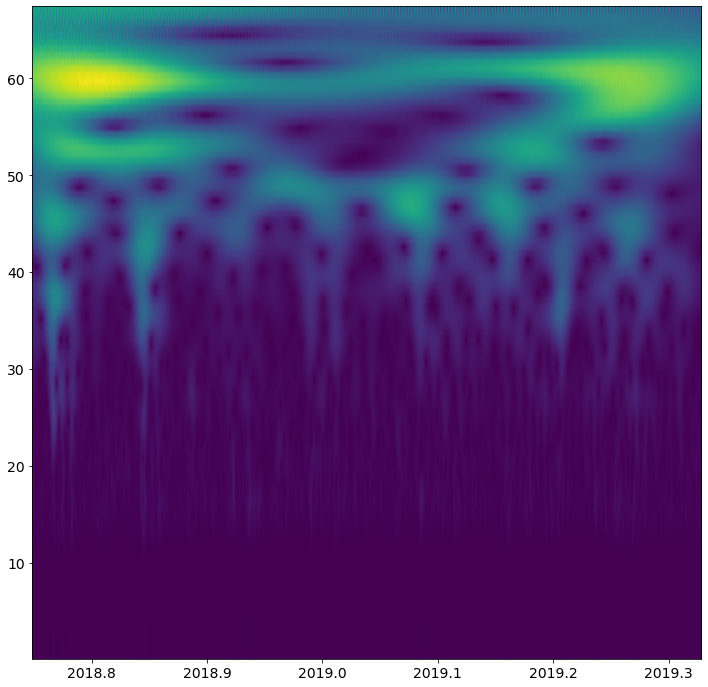

In [25]:
# # Implementation of matplotlib function 
# import matplotlib.pyplot as plt 
# import numpy as np 
# from matplotlib.colors import LogNorm 
 
    
# fig = plt.figure(figsize=(12,12))

# # dx, dy = 0.015, 0.05
# x = t 
# y = (1/freqs)*365 
   
# extent = np.min(x), np.max(x), np.min(y), np.max(y) 
   

# c= plt.imshow(cwtmatr, cmap ="viridis",
#            extent = extent,
#            aspect='auto',
#            origin='lower',
#           )   
# plt.show() 

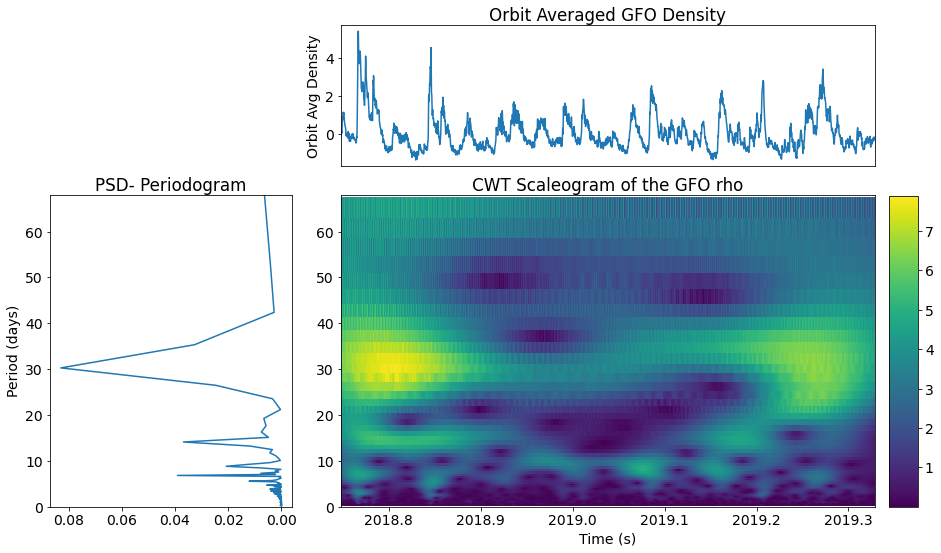

In [20]:
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.titlesize']='large'
plt.rcParams['axes.titlepad']= 2

plt.rcParams["legend.loc"] = 'best'





fig = plt.figure(figsize=(20,12))

ax_sig     = plt.subplot2grid((4,4),(1,2), rowspan = 1, colspan = 2) # top  
ax_psd     = plt.subplot2grid((4,4),(2,1), rowspan = 2, colspan = 1) # side
ax_contour = plt.subplot2grid((4,4),(2,2), rowspan = 2, colspan = 2, sharex=ax_sig, sharey=ax_psd) # bottom

pcm = ax_contour.pcolormesh(t, (1/freqs)*365, cwtmatr)
# pcm = ax_contour.pcolormesh(x_date, freqs, cwtmatr)
ax_contour.set_xlabel("Time (s)")
ax_contour.set_title("CWT Scaleogram of the GFO rho")
# ax_contour.set_yscale("log")
cbaxes = fig.add_axes([.91, 0.125, 0.02, .36])  # [xpos, ypos, width, height]
cb = plt.colorbar(pcm, cax = cbaxes)

###----------------------------------------------------------------------
###   Signal
ax_sig.plot(t, y_filt,   '-')
ax_sig.set_title("Orbit Averaged GFO Density")
ax_sig.set_ylabel("Orbit Avg Density")
# ax_sig.set_yscale("log")

ax_sig.xaxis.set_visible(False) # Hide only x axis

###----------------------------------------------------------------------
###   PERIODOGRAM
from scipy.signal import periodogram
def get_psd_values(y_values,  f_s):
    f_values, psd_values = periodogram(y_values, fs=f_s)
    return f_values, psd_values
f_values, psd_values = get_psd_values(y_filt, f_samp)
f_values  = f_values[1:]
psd_values= psd_values[1:]
# ax_psd.plot(psd_values, 1/f_values,   '-')
ax_psd.plot(psd_values, (1/f_values)*365,   '-')

# for i in [np.arange(1,8)]:
#     print(f" {(1/f_values)[indexes[-i]]*365:} d")
#     ax_psd.plot(psd_values[indexes[-i]]*365, (1/f_values)[indexes[-i]],  '.', markersize=10)


ax_psd.invert_xaxis()
ax_psd.set_ylim([0, 68])
ax_psd.set_ylabel("Period (days)")
ax_psd.set_title("PSD- Periodogram")
fig.constrained_layout=True 
# fig.tight_layout(pad=0)



In [ ]:
index_max = np.argmax(psd_values)
print(f"Dominant frequency at      {f_values[index_max]} Hz")
# print(f" correspondes to period at {1/f_values[index_max]} s ")
# print(f"                           {1/f_values[index_max]/60} m ")
# print(f"                           {1/f_values[index_max]/60/60} h ")
print(f"                           {1/f_values[index_max]/60/60/24} d ")

print()
indexes = np.argsort(psd_values)

for i in np.arange(1,10):
    print(f" {1/f_values[indexes[-i]]/60/60/24:5.1f} d")


In [ ]:
sys.exit(0)

In [ ]:

fig = go.Figure(data =
    go.Contour(
        z=cwtmatr,
        x=x_time, # horizontal axis
        y=freqs, # vertical axis
#             contours_coloring='heatmap',
            colorscale='Viridis',
))

fig.update_yaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log')
fig.update_xaxes(title_text="Time", exponentformat= 'power')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20),)

fig.update_layout(title=f"CWT--'cmor1.5-1.0'",
#                   autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )

fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')

In [ ]:
freqs

In [ ]:
import sys
sys.exit(0)

In [ ]:
import sys
sys.exit()

## Frequency analysis
In simple terms, the Continuous Wavelet Transform is an analysis tool similar to the Fourier Transform, in that it takes a time-domain signal and returns the signal’s components in the frequency domain. However, in contrast to the Fourier Transform, the Continuous Wavelet Transform returns a two-dimensional result, providing information in the frequency- as well as in time-domain. Therefore, it is useful for periodic signals which change over time.


In [ ]:
import numpy as np
import pywt





In [ ]:
# # plot fourier transform for comparison
# from numpy.fft import rfft, rfftfreq

# fig, axs = plt.subplots(1, 1, sharex=True)

# yf = rfft(y_signal)
# xf = rfftfreq(len(y_signal), sampling_period)
# plt.semilogx(xf, np.abs(yf))
# axs.set_xlabel("Frequency (Hz)")
# axs.set_title("Fourier Transform")
# plt.tight_layout()

In [ ]:
print(len(y_signal))
print(len(time))
freqs[:len(power_spectrum)]

In [ ]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.semilogy(x, y, 'b+')
ax_t.set_xlabel('Time [s]')
ax_w.semilogx(w, pgram)
ax_w.set_xlabel('frequency')
ax_w.set_ylabel('amplitude')
plt.show()

In [ ]:
w

In [ ]:
print(f" dominant frequncy {1/115.5827789} periods  ")

In [ ]:
((1/115.5827789)*9*86400)/60

In [ ]:
w

In [ ]:
# perform CWT
wavelet = "cmor1.5-1.0"

# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(y_signal, widths, wavelet, sampling_period=sampling_period)

# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(y_signal)
xf = rfftfreq(len(y_signal), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()

In [ ]:
cwtmatr
# freqs

In [ ]:
import sys
sys.exit()

In [ ]:
from scipy.fftpack import fft
import matplotlib.pyplot as plt


def get_fft_values(y_values, T, N, f_s):
    '''get_fft_values function above, the scipy.fftpack.fft function returns
       a vector of complex valued frequencies. Since they are complex valued,
       they will contain a real and an imaginary part. The real part of the 
       complex value corresponds with the magnitude, and the imaginary part 
       with the phase of the signal. Since we are only interested in the 
       magnitude of the amplitudes, we use np.abs() to take the real part of
       the frequency spectrum.
       The FFT of an input signal of N points, will return an vector of N points.
       The first half of this vector (N/2 points) contain the useful values of 
       the frequency spectrum from 0 Hz up to the Nyquist frequency of f_s / 2.
       The second half contains the complex conjugate and can be disregarded 
       since it does not provide any useful information.
       '''
    
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values



y_vals = gfo_df['D500_gfo'].values

t_n = 10
f_s = 0.1
N = len(y_vals)
T = t_n / N

print(f" Signal is sampled at a rate f_s = {f_s} Hz (or {1/f_s} s)")
print(f" the FFT will return the frequency spectrum up to a frequency of f_s / 2 = {f_s/2}Hz")

x_value = np.linspace(0,t_n,N)

f_values, fft_values = get_fft_values(y_vals, T, N, f_s)


### PLOT ###################################################################
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scattergl(  x=f_values,
                           y=fft_values,
                           mode='lines',
                           showlegend=False),
                           row=1, col=1)

font_dict=dict(family='Arial',size=11,color='black')
fig=plot_cleanformat_axes(fig,font_dict)

fig.update_yaxes(title_text="Amplitude",  
                  exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type="log", row=1, col=1)

fig.update_layout(title=f"Frequency domain of the signal",
                  autosize=True,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict, plot_bgcolor='white', 
                 )
fig.show(config = dict({
                'displayModeBar': False,'responsive': False,'staticPlot': True,
                'displaylogo': False,'showTips': False,}), 
        renderer='jpg')

# plt.semilogy(f_values, fft_values, linestyle='-', color='blue')
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('Amplitude', fontsize=16)
# plt.title("Frequency domain of the signal", fontsize=16)
# plt.show()
###################################################################

from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values
 
f_values, psd_values = get_psd_values(y_vals, T, N, f_s)
 
# plt.plot(f_values, psd_values, linestyle='-', color='blue')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('PSD [V**2 / Hz]')
# plt.show()

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scattergl(  x=f_values,
                           y=psd_values,
                           mode='lines',
                           showlegend=False),
                           row=1, col=1)

font_dict=dict(family='Arial',size=11,color='black')
fig=plot_cleanformat_axes(fig,font_dict)

fig.update_yaxes(title_text="PSD [V**2 / Hz]",  
                 exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 row=1, col=1)

fig.update_layout(title=f"PSD",
                  autosize=True,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict, plot_bgcolor='white', 
                 )
fig.show(config = dict({
                'displayModeBar': False,'responsive': False,'staticPlot': True,
                'displaylogo': False,'showTips': False,}), 
        renderer='jpg')